In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.nn import Parameter

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from torch.autograd import Variable
from IPython.display import clear_output

get_ipython().run_line_magic('pylab', 'inline')

Populating the interactive namespace from numpy and matplotlib


In [2]:
class ModuleWrapper(nn.Module):
    """Wrapper for nn.Module with support for arbitrary flags and a universal forward pass"""

    def __init__(self):
        super(ModuleWrapper, self).__init__()

    def set_flag(self, flag_name, value):
        setattr(self, flag_name, value)
        for m in self.children():
            if hasattr(m, 'set_flag'):
                m.set_flag(flag_name, value)

    def forward(self, x):
        for module in self.children():
            x = module(x)
        return x


class LinearVariance(ModuleWrapper):
    def __init__(self, in_features, out_features, bias=True):
        super(LinearVariance, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        #Your parameter is sigma, for standard deviation
        self.sigma = Parameter(torch.Tensor(out_features, in_features))
        #and bias, if option is true (default)
        if bias:
            self.bias = Parameter(torch.Tensor(1, out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.sigma.size(1))
        self.sigma.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.zero_()

    def forward(self, x):
        lrt_mean = self.bias
        lrt_std = torch.sqrt_(1e-16 + F.linear(x * x, self.sigma * self.sigma))
        #this is epsilon (unit normal gaussian)
        eps = Variable(lrt_std.data.new(lrt_std.size()).normal_())
        return lrt_mean + eps * lrt_std

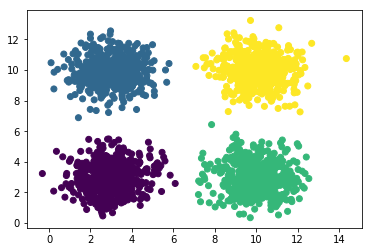

In [3]:
def get_data(means, variance=[[1, 0], [0, 1]], n=500):
    xs, ys = [], []
    
    #random multivariate normal distributions with expected values
    for c, mean in enumerate(means):
        x, y = np.random.multivariate_normal(mean, variance, n).T
        data, labels = np.array(list(zip(x, y))), np.zeros(n)+c
        xs.append(data)
        ys.append(labels)
        
    #asbatch
    X, y = np.vstack(xs).astype(float32),  np.hstack(ys).astype(long)

    return X, y

#These are your classes: 
Xtr, ytr = get_data([[3, 3], [3, 10], [10, 3], [10, 10]])
Xte, yte = get_data([[3, 3], [3, 10], [10, 3], [10, 10]])
pylab.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr)

In [13]:
#two inputs...
the_layer = LinearVariance(100, 2)

model = torch.nn.Sequential(
  torch.nn.Linear(2, 100),
  torch.nn.LeakyReLU(),
    
#fully connected layers
  torch.nn.Linear(100, 100),
  torch.nn.LeakyReLU(),
    
  torch.nn.Linear(100, 100),
  torch.nn.LeakyReLU(),
    
  torch.nn.Linear(100, 100),
  torch.nn.LeakyReLU(),
  
#And our 'variance' layer, two neurons
  the_layer,
  torch.nn.LeakyReLU(),
  
#One more fully connected...
  torch.nn.Linear(2, 100),
  torch.nn.LeakyReLU(),
  
#And softmax output to four classes
  torch.nn.Linear(100, 4),
  torch.nn.Softmax()
)

loss_fn = torch.nn.CrossEntropyLoss(size_average=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/home/alliedtoasters/miniconda3/envs/ptrch/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


iter 0: loss_train = 1.387 acc_test_one_sampl = 0.250 acc_test_ens = 0.250


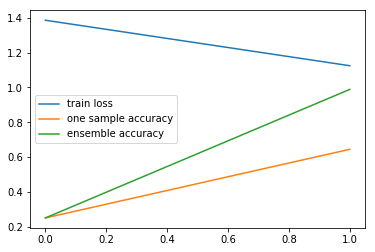

iter 1000: loss_train = 1.125 acc_test_one_sampl = 0.644 acc_test_ens = 0.989


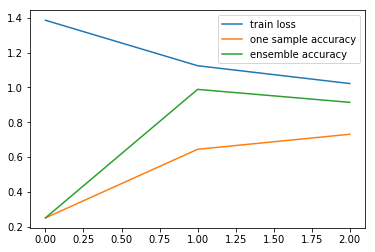

iter 2000: loss_train = 1.023 acc_test_one_sampl = 0.731 acc_test_ens = 0.914


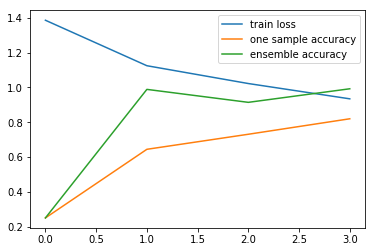

iter 3000: loss_train = 0.935 acc_test_one_sampl = 0.820 acc_test_ens = 0.993


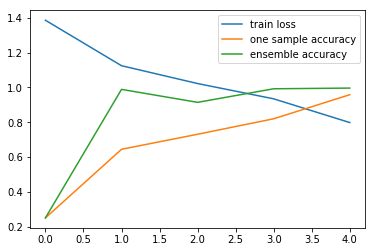

iter 4000: loss_train = 0.798 acc_test_one_sampl = 0.959 acc_test_ens = 0.997


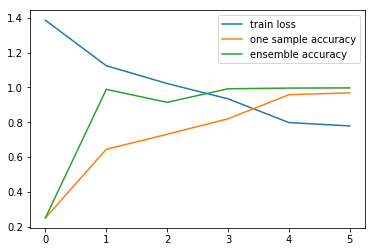

iter 5000: loss_train = 0.779 acc_test_one_sampl = 0.969 acc_test_ens = 0.998


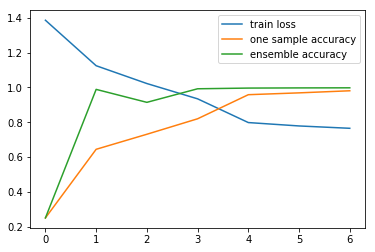

iter 6000: loss_train = 0.765 acc_test_one_sampl = 0.981 acc_test_ens = 0.998


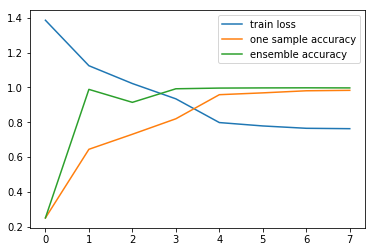

iter 7000: loss_train = 0.763 acc_test_one_sampl = 0.984 acc_test_ens = 0.998


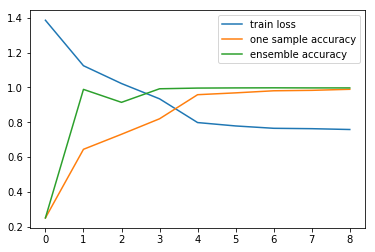

iter 8000: loss_train = 0.758 acc_test_one_sampl = 0.990 acc_test_ens = 0.998


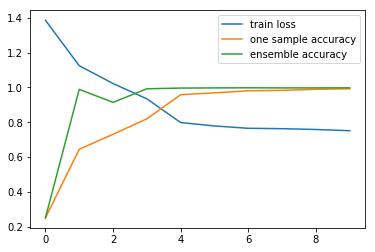

iter 9000: loss_train = 0.751 acc_test_one_sampl = 0.993 acc_test_ens = 0.998


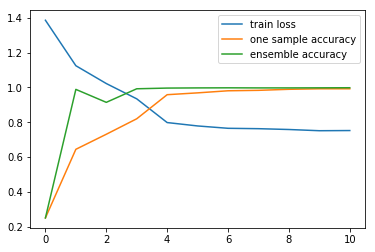

iter 10000: loss_train = 0.752 acc_test_one_sampl = 0.993 acc_test_ens = 0.999


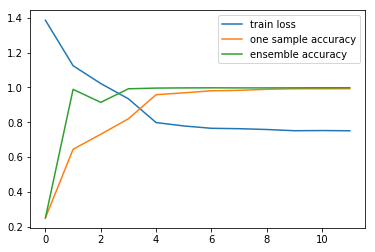

iter 11000: loss_train = 0.751 acc_test_one_sampl = 0.993 acc_test_ens = 0.999


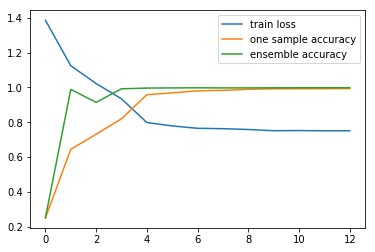

iter 12000: loss_train = 0.751 acc_test_one_sampl = 0.994 acc_test_ens = 0.999


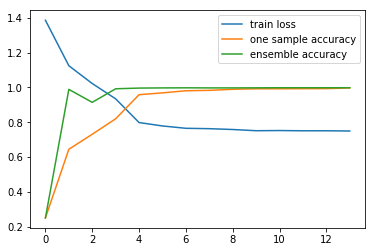

iter 13000: loss_train = 0.750 acc_test_one_sampl = 0.997 acc_test_ens = 0.999


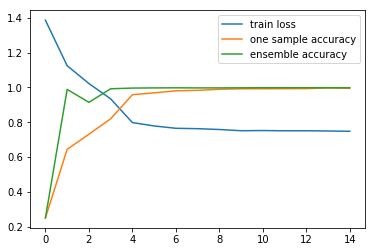

iter 14000: loss_train = 0.748 acc_test_one_sampl = 0.995 acc_test_ens = 0.999


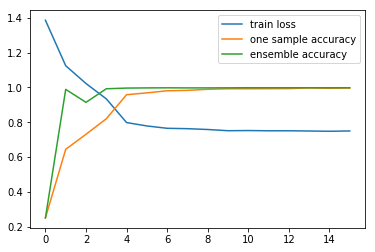

iter 15000: loss_train = 0.750 acc_test_one_sampl = 0.997 acc_test_ens = 0.999


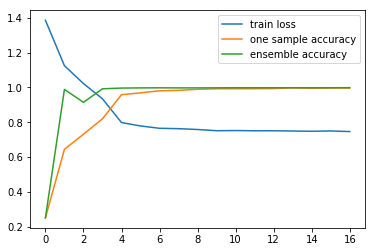

iter 16000: loss_train = 0.746 acc_test_one_sampl = 0.997 acc_test_ens = 0.999


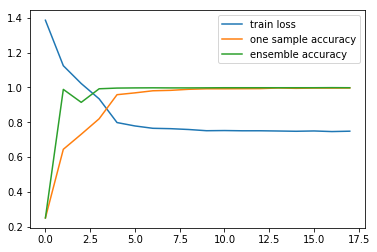

iter 17000: loss_train = 0.749 acc_test_one_sampl = 0.997 acc_test_ens = 0.999


KeyboardInterrupt: 

In [5]:
import matplotlib.pyplot as plt

def plot_me(tr_loss, one_sample, ensemble):
    """Plots optimization."""
    plt.plot(tr_loss, label='train loss')
    plt.plot(one_sample, label='one sample accuracy')
    plt.plot(ensemble, label='ensemble accuracy')
    plt.legend();
    plt.show();

tr_loss = []
one_sample = []
ensemble = []

for t in range(21000):
    y_pred = model(Variable(torch.from_numpy(Xtr)))
    y_true = Variable(torch.from_numpy(ytr)).long()
    loss = loss_fn(y_pred, y_true)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if t % 1000 == 0:
        y_test_sam = model(Variable(torch.from_numpy(Xte)))
        
        y_test_ens = model(Variable(torch.from_numpy(Xte)))
        for i in range(100):
            y_test_ens += model(Variable(torch.from_numpy(Xte))) 
        y_test_ens /= 101.
        
        loss = loss.item()
        acc_sam =  np.mean(y_test_sam.argmax(1).numpy() == yte)
        acc_ens = np.mean(y_test_ens.argmax(1).numpy() == yte)
        tr_loss.append(loss)
        one_sample.append(acc_sam)
        ensemble.append(acc_ens)
        te_acc = []
        if t > 3:
            plot_me(tr_loss, one_sample, ensemble)
        print('iter %s:' % t, 
              'loss_train = %.3f' % loss, 
              'acc_test_one_sampl = %.3f' % acc_sam,
              'acc_test_ens = %.3f' % acc_ens)

In [14]:
the_layer.get()

AttributeError: 'LinearVariance' object has no attribute 'get'